# Evaluating HRRR performance in wind gust potential

In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.spatial import distance

### Loading data

These datasets are not at the same time, so only general trends can be evaluated. 

Future - Find nearest METAR station to a HRRR prediction in order to evaluate specific predictions. 

In [2]:
Met_20170701 = Dataset(  # Metar
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/20170701_0000')
Met_20180613 = Dataset(  # Metar
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/20180613_0000')
Hrrr = Dataset(  # HRRR
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/extract2Da.esrl_hrrr.201718201001300.nc')

Removing any wind gusts > 10,000 m/s, should only be NAN fill values (3.4028235e+38). 

In [3]:
met_lon = Met_20170701.variables['longitude']
met_lat = Met_20170701.variables['latitude']
met_gust = Met_20170701.variables['windGust']
met_temp = Met_20170701.variables['temperature']
met_windspeed = Met_20170701.variables['windSpeed']
met_press = Met_20170701.variables['seaLevelPress']

top = 49.3457868  # north lat
left = -124.7844079  # west lon
right = -66.9513812  # east lon
bottom = 24.7433195  # south lat

cell = []
for g, lon, lat, t, ws, p in zip(met_gust, met_lon, met_lat, 
                                     met_temp, met_windspeed, met_press):
    if left <= lon <= right and bottom <= lat <= top:
        cell.append((g, lon, lat, t, ws, p))

met_arr = np.asarray(cell)
np.nan_to_num(met_arr, False, 0)
met_arr.shape

/Applications/anaconda3/envs/wind_gust/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


(4629, 6)

In [4]:
hrrr_gust = Hrrr.variables['GUST_P0_L1_GLC0']
hrrr_lat = Hrrr.variables['gridlat_0']
hrrr_lon = Hrrr.variables['gridlon_0']

hrrr_gust_flat = np.concatenate(hrrr_gust)
hrrr_lat_flat = np.concatenate(hrrr_lat)
hrrr_lon_flat = np.concatenate(hrrr_lon)

cell = []
for g, lon, lat in zip(hrrr_gust_flat, hrrr_lon_flat, hrrr_lat_flat):
    cell.append((g, lon, lat))

hrrr_arr = np.asarray(cell)
np.nan_to_num(hrrr_arr, False, 0)
hrrr_arr

array([[   7.6527605, -122.71953  ,   21.138123 ],
       [   7.6527605, -122.69286  ,   21.14511  ],
       [   7.6527605, -122.66619  ,   21.15209  ],
       ...,
       [   6.3402605,  -60.990314 ,   47.86277  ],
       [   6.2777605,  -60.953747 ,   47.85249  ],
       [   6.3402605,  -60.917194 ,   47.842194 ]], dtype=float32)

Looking for interesting features of the aggregate predictions. 

(0.0, 1000.0)

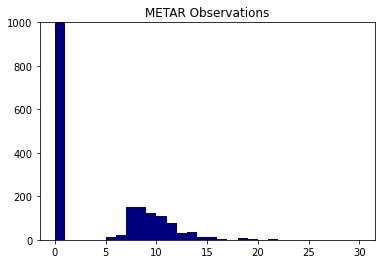

In [5]:
hist_metar = plt.hist(met_arr[:, 0], bins=30, color='navy', range=[0,30], )
plt.title("METAR Observations")
plt.ylim(0,1000)

(0.0, 1000000.0)

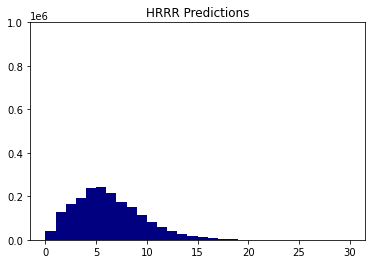

In [6]:
hist_hrrr = plt.hist(hrrr_arr[:, 0], bins=30, color='navy', range=[0,30], )
plt.title("HRRR Predictions")
plt.ylim(0,1000000)

### Comparing METAR observed wind gust to wind speed

"Time" would be a better x-axis, but I don't currently have data over time. 

In [7]:
met_arr[:,0].shape

(4629,)

Text(0, 0.5, 'Wind Gust (meter/sec)')

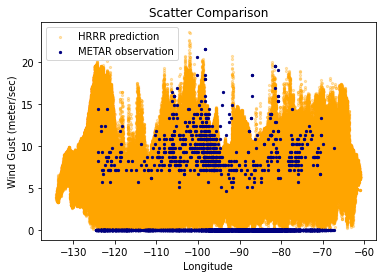

In [24]:
plt.scatter(hrrr_arr[:,1], hrrr_arr[:,0], color='orange', s=5, alpha=0.3, label='HRRR prediction')
plt.scatter(met_arr[:,1], met_arr[:,0],  color='navy', s=5, alpha=1, label='METAR observation')
plt.title("Scatter Comparison")
plt.legend(loc='upper left')
plt.xlabel("Longitude", size = 10)
plt.ylabel("Wind Gust (meter/sec)", size = 10)

Text(0, 0.5, 'meter/sec')

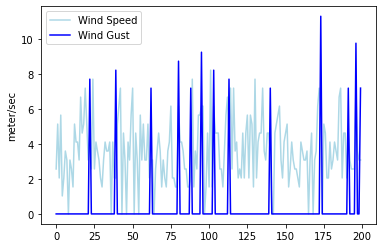

In [15]:
plt.plot(met_arr[0:200,4], color='LightBlue', label='Wind Speed')
plt.plot(met_arr[0:200,0], color='Blue', label='Wind Gust')
plt.legend()
plt.ylabel("meter/sec", size = 10)

### Testing the process of building the closest HRRR to METAR table. 
This scipy distance method is much faster.

In [10]:
def closest_node(metar, hrrrs):
    closest_index = distance.cdist([metar], hrrrs).argmin()
    return hrrrs[closest_index]

hrrr_data = hrrr_arr
lookup_dict = {}

for i in range(0,150): 
    metar_pt = (round(met_arr[i, 1],3), round(met_arr[i, 2],3))
    metar_gust = met_arr[i, 0]
    hrrr_pt = closest_node(metar_pt, hrrr_data[:, 1:3])
    hrrr_gust = hrrr_data[i, 0]
    lookup_dict[i] = {
        "metar": metar_pt,
        "hrrr": (round(hrrr_pt[0],3), round(hrrr_pt[1],3)),
        "hrrr gust": hrrr_gust,
        "metar gust": metar_gust
    }

#lookup_dict

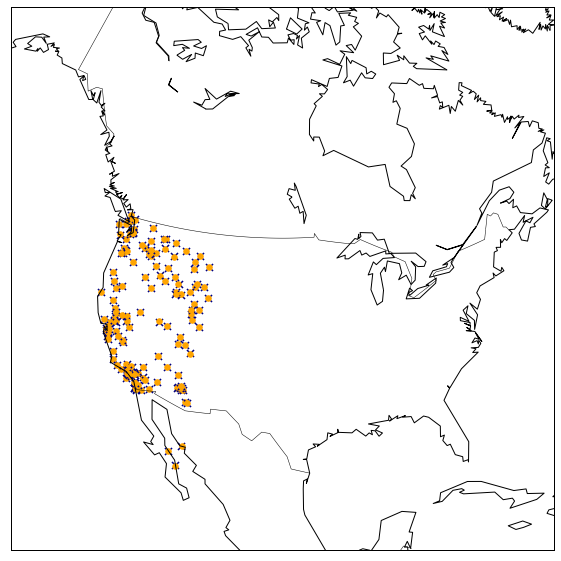

In [17]:
fig = plt.figure(figsize=(10, 10))
m = Basemap(projection='lcc', resolution='c',
            width=6E6, height=6E6,
            lat_0=45, lon_0=-100, )
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
parallels = np.arange(0., 81, 10.)
meridians = np.arange(10., 351., 20.)

for i in range(0,150):
    m.scatter(lookup_dict[i]['metar'][0], lookup_dict[i]['metar'][1], latlon=True, c='Navy', s=50, 
              marker='x', label="METAR station")
    m.scatter(lookup_dict[i]['hrrr'][0], lookup_dict[i]['hrrr'][1], latlon=True, c='Orange', s=30, 
              label="HRRR prediction point")

#plt.legend() Adds each label each time it runs through the loop
plt.show()

### Testing accuracy of HRRR predictions

Text(0, 0.5, 'meter/sec')

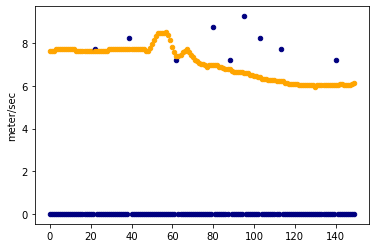

In [25]:
for i in range(0,150):
    plt.scatter(i, lookup_dict[i]['metar gust'], c='Navy', s=20, label="METAR station")
    plt.scatter(i, lookup_dict[i]['hrrr gust'], c='Orange', s=20, label="HRRR prediction point")
    
plt.ylabel("meter/sec", size = 10)
#plt.legend()

### Old version, with euclidean. 

Measures dist as points of latitude/longitude (I believe), not kilometers. Will need some sort of conversion to find one within 3km. 

In [ ]:
some_pt1 = [(10.76,2.9),(3.24,4.28),(7.98,1.98),(3.21,9.87)]
some_pt2 = [(11.87,6.87), (67.87,8.88), (44.44, 6.78), (9.81, 1.09), (6.91, 0.56), (8.76, 8.97), (8.21, 71.66)]

empty_dict = {}
count = 0
for i in range(len(some_pt1)):
    for j in range(len(some_pt2)):
        dist = distance.euclidean(some_pt1[i],some_pt2[j])
        if (dist < 5):
            count += 1
            empty_dict[count] = {
                "metar": some_pt1[i],
                "hrrr": some_pt2[j],
                "distance": round(dist, 3)
            }

empty_dict